In [1]:
# Sample API
import flowx
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

Re   = 100.0
dt   = 0.01
tmax = 10.

# Define cell-centered variable names
center_vars = ['pres', 'divp', 'divc','asol','eror']
face_vars   = ['velc', 'hvar','asol','eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 1.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

In [3]:
t  = 0.0
nt = 0

ins_stats = dict()

while t <= tmax:
    
    # Calculate predicted velocity: u* = dt*H(u^n)
    flowx.ins.predictor(gridx, gridy, 'velc', 'hvar', Re, dt)
    
    # Calculate RHS for the pressure Poission solver div(u)/dt
    flowx.ins.divergence(gridc, gridx, gridy, 'velc', 'divp', ifac=dt)
    
    # Solve the pressure Poisson equation 
    ins_stats['ites'], ins_stats['res'] = flowx.poisson.solve_jacobi(gridc, 'pres', 'divp',
                                                                       maxiter=10000, tol=1e-9)
    
    # Calculate corrected velocity u^n+1 = u* - dt * grad(P) 
    flowx.ins.corrector(gridc, gridx, gridy, 'velc', 'pres', dt)
    
    # Calculate divergence of the corrected velocity to display stats
    flowx.ins.divergence(gridc, gridx, gridy, 'velc', 'divc')
    
    # Calculate stats
    ins_stats.update(flowx.ins.stats(gridc, gridx, gridy, 'velc', 'pres', 'divc'))
    
    # Display stats
    if nt % 10 == 0:
        flowx.io.display_stats(t, ins_stats)   
    
    t += dt
    nt += 1
    

------------ Time = 0.0 ---------------
Number of poisson iterations    : 8298
Final poisson residual : 9.999017012083382e-10
Max, Min, U   : 2.0, -0.06368603696318668
Max, Min, V   : 0.15978098482935374, -0.15978098482935374
Max, Min, P   : 1.821370116487896, -1.821370116487896
Max, Min, DIV : 8.822232144822806e-08, -8.822232144822806e-08


------------ Time = 0.09999999999999999 ---------------
Number of poisson iterations    : 5427
Final poisson residual : 9.986693430805327e-10
Max, Min, U   : 2.0, -0.13534631828869778
Max, Min, V   : 0.3062757792420776, -0.31416379318957555
Max, Min, P   : 1.1784764920745354, -0.870387187021241
Max, Min, DIV : 9.131347233903853e-08, -9.123620848877287e-08


------------ Time = 0.20000000000000004 ---------------
Number of poisson iterations    : 4721
Final poisson residual : 9.9872680125128e-10
Max, Min, U   : 2.0, -0.15408003056231664
Max, Min, V   : 0.3200511957643647, -0.37180322360235246
Max, Min, P   : 1.1785200206184425, -0.7890553227470622
M

KeyboardInterrupt: 

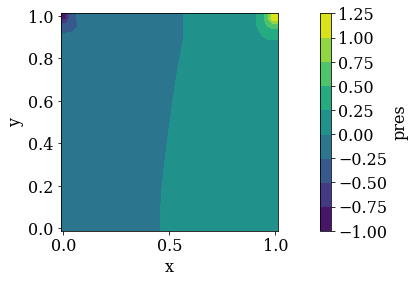

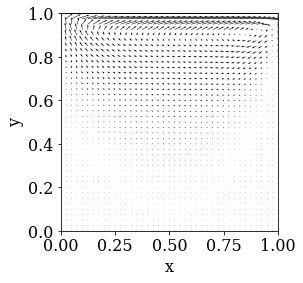

In [4]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_vector(gridx,gridy,'velc')